# Geographical Clustering Before Modeling: Predict the Occurrence of Violence During a Protest?

The previous models performed well on the June dataset but not on the entire dataset. Thus they do not seem to be good robust models for predicting protest violence. We had noticed differences in violence rates between big cities and smaller cities. Let's cluster by population before developing models.

# Imports

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression # multiple linear regression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier # k-nearest neighbors
from sklearn.tree import DecisionTreeClassifier # decision tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostRegressor, AdaBoostClassifier  # random forest, extratrees
from sklearn.svm import SVC # support vector regressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, f1_score, confusion_matrix, plot_confusion_matrix, classification_report

from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(42)

## Read in data

In [125]:
df = pd.read_csv('../Data/integrated_protest.csv')

# function to binarize protest status
def yes_violence(row):
    if row == 'Peaceful protest':
        return 0
    else:
        return 1
    
# create binarized violence column based on sub_event_type
df['violence'] = df['sub_event_type'].apply(yes_violence)

# fill 'NA' with 'none'
df['assoc_actor_1'] = df['assoc_actor_1'].fillna('none')

# don't include attendee count because we never know ahead of time how many people are actually going to show up, so can't use that to predict
features = ['month','city','state','event_type','actor1','assoc_actor_1','notes','totalpop','povertyrate','percentbachelor',
            'sqmiles','mayorrep','blackmayor','dem','rep','unarmed_deaths_pc','violence']

df_subset = df[features].copy()
df_subset.dropna(inplace=True)

### Figure out how to separate dataset by population

In [94]:
stats = df_subset['totalpop'].describe()
stats

count    1.540300e+04
mean     4.682896e+05
std      7.541352e+05
min      3.005500e+04
25%      7.170900e+04
50%      1.768220e+05
75%      5.818470e+05
max      3.793097e+06
Name: totalpop, dtype: float64

Separate dataset by totalpop.

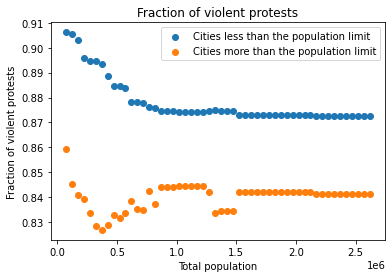

In [95]:
# Check baseline violence fraction

pop = []
lopop_frac = []
hipop_frac = []
for i in range(round(stats[4]),round(2.66e6),50000):
    lopop = df_subset[df_subset['totalpop']<i]
    hipop = df_subset[df_subset['totalpop']>=i]
    
    pop.append(i)
    loval = lopop['violence'].value_counts(normalize=True).sort_index(ascending=True)[0]
    hival = hipop['violence'].value_counts(normalize=True).sort_index(ascending=True)[0]
    lopop_frac.append(loval)
    hipop_frac.append(hival)

plt.scatter(pop,lopop_frac)
plt.scatter(pop,hipop_frac)
plt.xlabel('Total population')
plt.ylabel('Fraction of violent protests')
plt.legend(['Cities less than the population limit','Cities more than the population limit'])
plt.title('Fraction of violent protests')
plt.show()

* The fraction of violent protests levels off at a population threshold of ~900,000
* The fraction of violent protests is lowest at a population threshold of ~400,000. 
    * We'll use 400,000 as the population level at which to split our dataset.

## Set up original dataset for population split

In [126]:
model_features = ['month','totalpop','povertyrate','percentbachelor','sqmiles','mayorrep','blackmayor','dem','rep','unarmed_deaths_pc','violence']
df_model = df_subset[model_features]
df_model.reset_index(inplace=True)

In [97]:
# split the assoc_actor_1 up, and create dummified columns

# join all entries in the 'assoc_actor_1' column into 1, split by ;
assoc_actor_1 = ';'.join(df_subset['assoc_actor_1'])

# split this giant string into a list of individual actors
assoc_actor_split = [x.strip() for x in assoc_actor_1.split(';')]

# Create a list of all actors
assoc_actor = []
for i in range(len(assoc_actor_split)):
    if assoc_actor_split[i] not in assoc_actor:
        assoc_actor.append(assoc_actor_split[i])

In [98]:
# create empty df with the columns of interest and the same number of rows as df_model
temp_df = pd.DataFrame(index = range(df_model.shape[0]), columns = assoc_actor) 

In [100]:
# manual OHE assoc_actor list
# if an item in the assoc_actor list exists in the assoc_actor_1 string, assign that column = 1
for j in range(len(assoc_actor)):
    for ind in range(df_subset.shape[0]):
        if assoc_actor[j] in df_subset['assoc_actor_1'].iloc[ind]:
            temp_df[assoc_actor[j]].iloc[ind]=1
        else:
            temp_df[assoc_actor[j]].iloc[ind]=0

In [127]:
# concatenate with df_model
df_model = pd.concat([df_model, temp_df], axis=1)

df_model.drop(columns = 'index', inplace=True)
df_model.head()

,month,totalpop,povertyrate,percentbachelor,sqmiles,mayorrep,blackmayor,dem,rep,unarmed_deaths_pc,violence,Health Workers (United States),none,BLM: Black Lives Matter,Government of the United States (2017-2021),Women (United States),CP: CodePink,ANSWER: Act Now to Stop War and End Racism,African American Group (United States),Christian Group (United States),Iranian Group (United States),Veterans for Peace,Former Military Forces of the United States (2017-2021),Red Nation,Native American Group (United States),Indivisible Movement,Filipino Group (United States),Students (United States),Poor People's Campaign,GOP: Republican Party,MDA: Moms Demand Action for Gun Sense in America,Teachers (United States),PSL: Party for Socialism and Liberation,White Nationalists (United States),Protestant Christian Group (United States),DEM: Democratic Party,DSA: Democratic Socialists of America,Los Brown Berets,Latinx Group (United States),MO: MoveOn,Washington State III%ers,Patriot Prayer,Muslim Group (United States),Jewish Group (United States),Mexican Group (United States),Labour Group (United States),"AFSCME: American Federation of State, County and Municipal Employees",FNB: Food Not Bombs,Philadelphia Housing Action,Interfaith Group (United States),Chinook Tribal Group (United States),Chinese Group (United States),NAACP: National Association for the Advancement of Colored People,WILPF: Women's International League for Peace and Freedom,Unite Here,Arab Ethnic Group (United States),Afghan Group (United States),Iraqi Group (United States),XR: Extinction Rebellion,Citizen Action,CASA In Action,SM: Sunrise Movement,AFL-CIO: American Federation of Labor and Congress of Industrial Organizations,LGBT (United States),RTL: Right To Life,ACLU: American Civil Liberties Union,USW: United Steelworkers,NNU: National Nurses United,SEIU: Service Employees International Union,Lawyers (United States),CAN: Climate Action Network,VOCAL-NY: Voices Of Community Activists and Leaders - New York,Police Forces of the United States (2017-2021),IBT: International Brotherhood of Teamsters,Indian Group (United States),PP: Planned Parenthood,Evangelical Christian Group (United States),Catholic Christian Group (United States),Unitarian Universalist Group (United States),Proud Boys,Animal Save Movement,VCDL: Virginia Citizens Defense League,Three Percenters (III%),Oath Keepers,LFM: Light Foot Militia,Unidentified Communal Militia (United States),CMM: Citizens Militia of Mississippi,Military Forces of the United States (2017-2021),PETA: People for the Ethical Treatment of Animals,Fight for 15,WTP: We the People,Sierra Club,Open Carry Texas,Vietnamese Group (United States),Bloodstained Men,MRNY: Make the Road New York,LULAC: League of United Latin American Citizens,Refuse Fascism,NRA: National Rifle Association,Wet'suwet'en Indigenous Group (United States),MC: Cosecha Movement,NAN: National Action Network,AFT: American Federation of Teachers,JVP: Jewish Voice for Peace,AWD: Atomwaffen Division,Greenpeace,Abolish ICE,UAW: United Automobile Workers,Asian American Group (United States),NLM: Native Lives Matter,MMIWG: Missing and Murdered Indigenous Women and Girls,Chippewa Tribal Group (United States),Palestinian American Group (United States),Seneca Tribal Group (United States),Kashmiri Ethnic Group (United States),SDA: Students Demand Action,MOF: Mothers Out Front,DREAMers Movement (United States),APSP: African People's Socialist Party,Dominican Group (United States),Boogaloo Boys,Pro-Police Group (United States),South Sudanese Group (United States),Hmong Ethnic Group (United States),DXE: Direct Action Everywhere,Hoopa Valley Tribal Group (United States),Yurok Tribal Group (United States),Karuk Tribal Group (United States),Miwok Tribal Group (United States),Winnemem Wintu Tribal Group (United States),Sikh Group (United States),Cancel the Rents Movement,UFW: United Farm Workers of America,Farmers (United States),BNHR: Border Network for Human Rights,RAICES: Refugee and Immigran

## Split by population

In [128]:
cutoff = 400000

lopop = df_model[df_model['totalpop']<cutoff] # dataset with populations <cutoff
hipop = df_model[df_model['totalpop']>=cutoff] # dataset with populations >cutoff

lopop.shape, hipop.shape

((10580, 331), (4823, 331))

In [129]:
display(lopop['violence'].value_counts(normalize=True))
display(hipop['violence'].value_counts(normalize=True))

0    0.891304
1    0.108696
Name: violence, dtype: float64

0    0.826664
1    0.173336
Name: violence, dtype: float64

Use the June data from each population set to build models, and compare performance when applied to the larger population.

## Lopop (cities with population < 400,000)

In [130]:
Xjune_lopop = lopop[lopop['month']==6]

XjuneL = Xjune_lopop.drop(columns=['month','violence'])
yjuneL = Xjune_lopop['violence']

### Apply Supervised Classification Models

In [131]:
X_train, X_test, y_train, y_test = train_test_split(XjuneL, yjuneL, test_size=0.2, random_state=42, stratify=yjuneL)

In [132]:
models = [('lr', LogisticRegression()),
          ('knn', KNeighborsClassifier()),
          ('cart', DecisionTreeClassifier()),
          ('bag', BaggingClassifier()),
          ('rf', RandomForestClassifier()),
          ('ada', AdaBoostClassifier()),
          ('svc', SVC())
         ]

ss_params = {'ss__with_mean':[True, False], 'ss__with_std':[True, False]}

params = [{'lr__solver': ['liblinear'], 'lr__C': [2, 5, 10], 'lr__penalty': ['l1','l2'], 'lr__max_iter': [100, 500, 1000]}, # logreg
          {'knn__n_neighbors':[1, 3, 5, 7, 11, 23], 'knn__weights':['uniform','distance']}, # knn
         {'cart__max_depth': [2, 3, 5, 7], 'cart__min_samples_split': [5, 7, 10, 15, 20], 'cart__min_samples_leaf': [2, 3, 4, 5, 6], 
          'cart__ccp_alpha': [0, 0.001, 0.01, 0.1, 1, 10], 'cart__random_state': [42]}, # decision tree
         {'bag__n_estimators': [10, 100, 200], 'bag__random_state': [42], 'bag__n_jobs': [4]}, # bagging
         {'rf__max_depth': [5], 'rf__random_state': [42]}, # random forest
         {'ada__n_estimators': [10, 100, 200], 'ada__random_state': [42]}, # adaboost
         {'svc__C': np.linspace(0, 5, 10), 'svc__kernel':['rbf','polynomial'], 'svc__degree':list(range(4)), 'svc__random_state':[42]}] # SVC

In [133]:
pipelines = []
pipe_params = []
pipe_gs = []

for ind in range(len(models)):
    pipelines.append(Pipeline([('ss', StandardScaler()),
                             models[ind]]))
    
    res = ss_params.copy()
    res.update(params[ind])
    pipe_params.append(res)
    
    pipe_gs.append(GridSearchCV(Pipeline([('ss', StandardScaler()), models[ind]]),
                  res,
                  cv=5,
                  verbose=1,
                  n_jobs=4))

In [134]:
evaluations_juneL = []

for gs in pipe_gs:
    gs.fit(X_train, y_train)
    
    evaluations_juneL.append({
        'pipe': [step[0] for step in gs.estimator.steps],
        'train score': gs.score(X_train, y_train),
        'cross val': cross_val_score(gs.estimator, X_train, y_train, cv=5).mean(),
        'test score': gs.score(X_test, y_test),
        'f1-score (train)': f1_score(y_true = y_train, y_pred = gs.predict(X_train)),
        'f1-score (test)': f1_score(y_true = y_test, y_pred = gs.predict(X_test))
    })
    
evaluations_juneL_df = pd.DataFrame(evaluations_juneL)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
/Users/aida/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   10.0s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:   18.9s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.4s
/Users/aida/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.1s
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed:   18.8s finished


Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   19.4s
[Parallel(n_jobs=4)]: Done 1576 tasks      | elapsed:   34.9s
[Parallel(n_jobs=4)]: Done 2476 tasks      | elapsed:   55.5s
[Parallel(n_jobs=4)]: Done 3576 tasks      | elapsed:  1.3min
/Users/aida/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=4)]: Done 4876 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6376 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 8076 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 9976 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 12000 out of 12000 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/Users/aida/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:   13.2s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    1.3s finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:   10.3s finished


Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   29.6s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 1576 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 1600 out of 1600 | elapsed:  2.0min finished


In [135]:
evaluations_juneL_df

,pipe,train score,cross val,test score,f1-score (train),f1-score (test)
0,"[ss, lr]",0.912963,0.906944,0.907407,0.189655,0.074074
1,"[ss, knn]",0.913889,0.906019,0.909259,0.354167,0.268657
2,"[ss, cart]",0.912500,0.893056,0.909259,0.181818,0.109091
3,"[ss, bag]",0.943981,0.891204,0.898148,0.653295,0.303797
4,"[ss, rf]",0.904167,0.900926,0.903704,0.018957,0.000000
5,"[ss, ada]",0.903704,0.906019,0.896296,0.181102,0.096774
6,"[ss, svc]",0.914352,0.910185,0.907407,0.206009,0.074074


In [142]:
Xjune_lopop['violence'].value_counts(normalize=True)

0    0.903333
1    0.096667
Name: violence, dtype: float64

That did not work for small cities (test score is not any better than the baseline model). What about large cities?

## Hipop (cities with population > 400,000)

In [137]:
Xjune_hipop = hipop[hipop['month']==6]

XjuneH = Xjune_hipop.drop(columns=['month','violence'])
yjuneH = Xjune_hipop['violence']

### Apply Supervised Classification Models

In [138]:
X_train, X_test, y_train, y_test = train_test_split(XjuneH, yjuneH, test_size=0.2, random_state=42, stratify=yjuneH)

In [139]:
evaluations_juneH = []

for gs in pipe_gs:
    gs.fit(X_train, y_train)
    
    evaluations_juneH.append({
        'pipe': [step[0] for step in gs.estimator.steps],
        'train score': gs.score(X_train, y_train),
        'cross val': cross_val_score(gs.estimator, X_train, y_train, cv=5).mean(),
        'test score': gs.score(X_test, y_test),
        'f1-score (train)': f1_score(y_true = y_train, y_pred = gs.predict(X_train)),
        'f1-score (test)': f1_score(y_true = y_test, y_pred = gs.predict(X_test))
    })
    
evaluations_juneH_df = pd.DataFrame(evaluations_juneH)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:   13.2s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed:    3.1s finished


Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 1400 tasks      | elapsed:   10.0s
[Parallel(n_jobs=4)]: Done 3400 tasks      | elapsed:   23.9s
[Parallel(n_jobs=4)]: Done 6200 tasks      | elapsed:   44.1s
[Parallel(n_jobs=4)]: Done 9800 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 12000 out of 12000 | elapsed:  1.5min finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    5.2s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.9s finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    3.9s finished


Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 728 tasks      | elapsed:   12.5s
[Parallel(n_jobs=4)]: Done 1600 out of 1600 | elapsed:   26.8s finished


In [140]:
evaluations_juneH_df

,pipe,train score,cross val,test score,f1-score (train),f1-score (test)
0,"[ss, lr]",0.865522,0.856927,0.874286,0.356164,0.421053
1,"[ss, knn]",0.895565,0.849805,0.880000,0.587571,0.553191
2,"[ss, cart]",0.884120,0.854090,0.874286,0.566845,0.560000
3,"[ss, bag]",0.895565,0.859805,0.885714,0.605405,0.583333
4,"[ss, rf]",0.844063,0.856978,0.834286,0.167939,0.064516
5,"[ss, ada]",0.864092,0.855519,0.874286,0.344828,0.421053
6,"[ss, svc]",0.866953,0.861233,0.874286,0.367347,0.421053


In [143]:
Xjune_hipop['violence'].value_counts(normalize=True)

0    0.828375
1    0.171625
Name: violence, dtype: float64

This looks promising. The Bagging Classifier works best here, with a test score of 89%. 

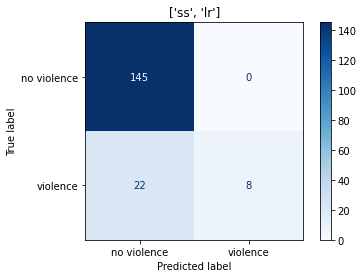

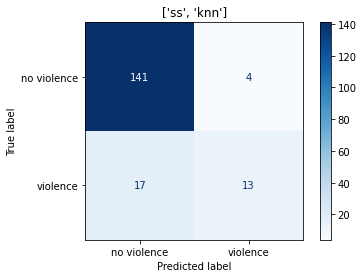

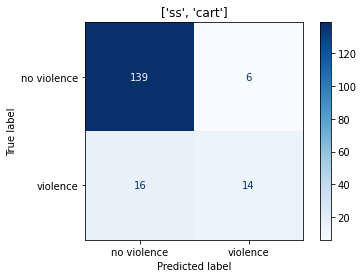

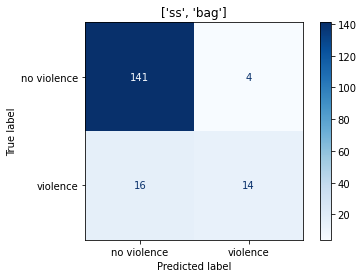

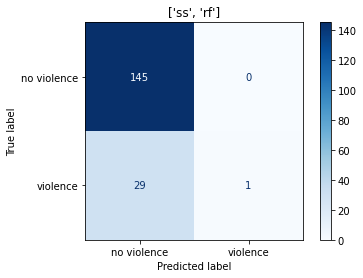

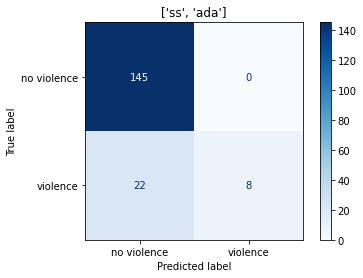

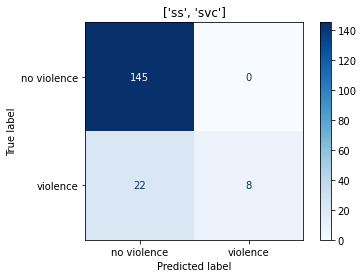

In [144]:
for gs in pipe_gs:
    plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', 
                      values_format='d', display_labels=['no violence','violence']);
    plt.title([step[0] for step in gs.estimator.steps])

Let's apply these models to the larger dataset (for the large cities).

In [145]:
### Apply models to larger dataset for large cities.

In [146]:
X_hipop = hipop[hipop['month']!=6]

XH = X_hipop.drop(columns=['month','violence'])
yH = X_hipop['violence']

### Apply Supervised Classification Models

In [147]:
X_train, X_test, y_train, y_test = train_test_split(XH, yH, test_size=0.2, random_state=42, stratify=yH)

In [149]:
evaluations_H = []

for gs in pipe_gs:
    gs.fit(X_train, y_train)
    
    evaluations_H.append({
        'pipe': [step[0] for step in gs.estimator.steps],
        'train score': gs.score(X_train, y_train),
        'cross val': cross_val_score(gs.estimator, X_train, y_train, cv=5).mean(),
        'test score': gs.score(X_test, y_test),
        'f1-score (train)': f1_score(y_true = y_train, y_pred = gs.predict(X_train)),
        'f1-score (test)': f1_score(y_true = y_test, y_pred = gs.predict(X_test))
    })
    
evaluations_H_df = pd.DataFrame(evaluations_H)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
/Users/aida/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.5s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:   38.9s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/Users/aida/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   28.7s
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed:   36.2s finished


Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.0s
/Users/aida/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   14.6s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   31.9s
[Parallel(n_jobs=4)]: Done 1576 tasks      | elapsed:   58.5s
[Parallel(n_jobs=4)]: Done 2476 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 3576 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 4876 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 6376 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 8076 tasks      | elapsed:  5.0min
[Parallel(n_jobs=4)]: Done 9976 tasks      | elapsed:  6.2min
[Parallel(n_jobs=4)]: Done 12000 out of 12000 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/Users/aida/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:   22.4s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    1.7s finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:   16.2s finished


Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/Users/aida/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=4)]: Done  70 tasks      | elapsed:    9.9s
[Parallel(n_jobs=4)]: Done 220 tasks      | elapsed:   44.5s
[Parallel(n_jobs=4)]: Done 470 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 820 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 1270 tasks      | elapsed:  4.3min
[Parallel(n_jobs=4)]: Done 1600 out of 1600 | elapsed:  5.4min finished


In [151]:
evaluations_H_df

,pipe,train score,cross val,test score,f1-score (train),f1-score (test)
0,"[ss, lr]",0.849953,0.842989,0.844304,0.270769,0.185430
1,"[ss, knn]",0.871478,0.820824,0.856962,0.483461,0.402116
2,"[ss, cart]",0.858500,0.845208,0.840506,0.374825,0.284091
3,"[ss, bag]",0.870845,0.839187,0.849367,0.490000,0.419512
4,"[ss, rf]",0.838557,0.844890,0.835443,0.132653,0.097222
5,"[ss, ada]",0.849319,0.842988,0.840506,0.276596,0.171053
6,"[ss, svc]",0.856917,0.847737,0.848101,0.304615,0.230769


In [152]:
X_hipop['violence'].value_counts(normalize=True)

0    0.826285
1    0.173715
Name: violence, dtype: float64

This looks promising as well. The Bagging Classifier results in a test score 2% better than the baseline model, with a test f1-score of 0.42. We could use PCA and/or neural networks to try and improve the performance of this model. And this indicates that with better clustering, it may be possible to develop better models for the other cities as well.